Import the required libraries and modules

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import seaborn as sn

from keras import layers
from PIL import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix

Load CIFAR-10 dataset using keras and distribute it to train and test sets. Data rescaling will produce in on of the first layers of our CNN

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train, y_test = y_train.flatten(), y_test.flatten()

train_image_size = (32, 32)

In [ ]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Look at images we're working with

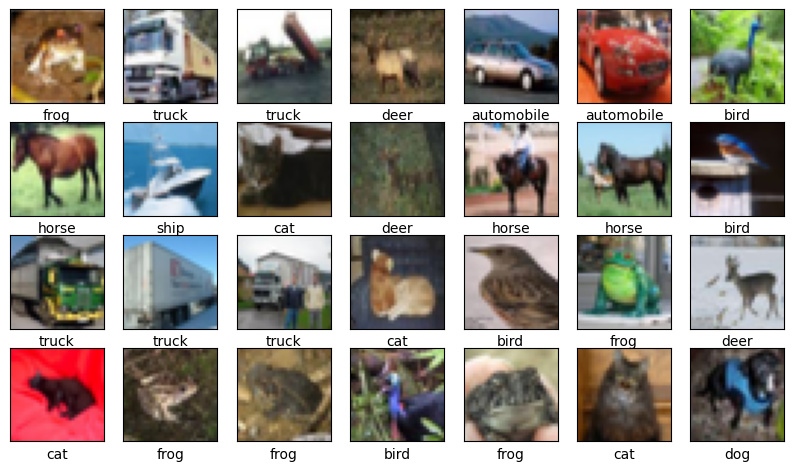

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(28):
  plt.subplot(7,7,i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
  plt.xlabel(classes[y_train[i]])
plt.show()

For building first model define function **make_model**. It simply has Rescaling layer and Resizing layer(added to allow the test data to be of any size), two convolutional layers with 32 filters, two convolutional layers with 64 filters, one hidden layer with 128 neurons and output layer

In [ ]:
def make_model(train_image_size, num_classes):


  (height, width) = train_image_size

  model = keras.models.Sequential()

  model.add(layers.Rescaling(1./255))
  model.add(layers.Resizing(height, width))

  model.add(layers.Conv2D(32, (3, 3), input_shape=train_image_size + (3,), activation='relu',  padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding='same'))

  model.add(layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same'))

  model.add(layers.MaxPooling2D(pool_size = (2, 2)))


  model.add(layers.Flatten())

  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(num_classes, activation='softmax'))

  return model


In [ ]:
model = make_model(train_image_size, len(classes))

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x_train,
          y_train,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 14s 7ms/step - loss: 1.4068 - accuracy: 0.4905 - val_loss: 1.0189 - val_accuracy: 0.6373
Epoch 2/20
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9182 - accuracy: 0.6768 - val_loss: 0.9248 - val_accuracy: 0.6766
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7371 - accuracy: 0.7409 - val_loss: 0.8035 - val_accuracy: 0.7161
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6111 - accuracy: 0.7868 - val_loss: 0.7699 - val_accuracy: 0.7370
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5070 - accuracy: 0.8202 - val_loss: 0.7597 - val_accuracy: 0.7485
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4220 - accuracy: 0.8503 - val_loss: 0.8524 - val_accuracy: 0.7400
Epoch 7/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3424 - accuracy: 0.8769 - val_loss: 0.9006 - val_ac

**accuracy_plot** using to plot model accuracy on training and test data

In [ ]:
def accuracy_plot(history):
  plt.plot(history.history['accuracy'], label = 'accuracy')
  plt.plot(history.history['val_accuracy'], label = 'test_accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.3, 1])
  plt.legend(["Train", "Test"], loc="lower right")

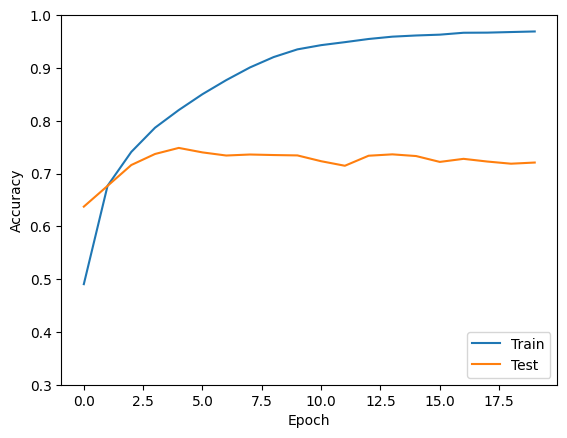

In [ ]:
accuracy_plot(history)

As we see, model overfitting. Its accuracy doesn't change noticeably on training data after 4 epoch and at the same time accuracy on training data increases rapidly

Let's use image augmentation to avoid overfitting. For this create ImageDataGenerator that will randomly flip images horizontally, shift it randomly vertically and horizontally on until 15% fraction of total height/width respectively

In [ ]:
image_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    height_shift_range=0.15,
    width_shift_range=0.15,
    zoom_range=0.15,
)

train_generator = image_generator.flow(x_train, y_train, batch_size=64)

Also add several convolutional layers with 128 filters

In [ ]:
def make_model_aug(train_image_size, num_classes):

  (height, width) = train_image_size

  model = keras.models.Sequential()

  model.add(layers.Input(shape=(None,None, 3)))

  model.add(layers.Rescaling(1./255))
  model.add(layers.Resizing(height, width))

  model.add(layers.Conv2D(32, (3, 3), input_shape=(train_image_size + (3,)), activation='relu',  padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding='same'))

  model.add(layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same'))

  model.add(layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding='same'))

  model.add(layers.MaxPooling2D(pool_size = (2, 2)))



  model.add(layers.Flatten())


  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(num_classes, activation='softmax'))

  return model



In [ ]:
model2 = make_model_aug(train_image_size, len(classes))

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model2.fit(train_generator,
                     epochs=20,
                     validation_data=(x_test, y_test))

Epoch 1/20
782/782 [==============================] - 41s 44ms/step - loss: 1.6676 - accuracy: 0.3866 - val_loss: 1.3219 - val_accuracy: 0.5198
Epoch 2/20
782/782 [==============================] - 33s 42ms/step - loss: 1.2470 - accuracy: 0.5502 - val_loss: 1.0684 - val_accuracy: 0.6206
Epoch 3/20
782/782 [==============================] - 31s 40ms/step - loss: 1.0625 - accuracy: 0.6198 - val_loss: 0.9174 - val_accuracy: 0.6800
Epoch 4/20
782/782 [==============================] - 34s 44ms/step - loss: 0.9306 - accuracy: 0.6719 - val_loss: 0.8423 - val_accuracy: 0.7113
Epoch 5/20
782/782 [==============================] - 32s 41ms/step - loss: 0.8430 - accuracy: 0.7022 - val_loss: 0.7953 - val_accuracy: 0.7224
Epoch 6/20
782/782 [==============================] - 32s 40ms/step - loss: 0.7757 - accuracy: 0.7273 - val_loss: 0.7254 - val_accuracy: 0.7505
Epoch 7/20
782/782 [==============================] - 33s 43ms/step - loss: 0.7323 - accuracy: 0.7427 - val_loss: 0.7136 - val_accuracy:

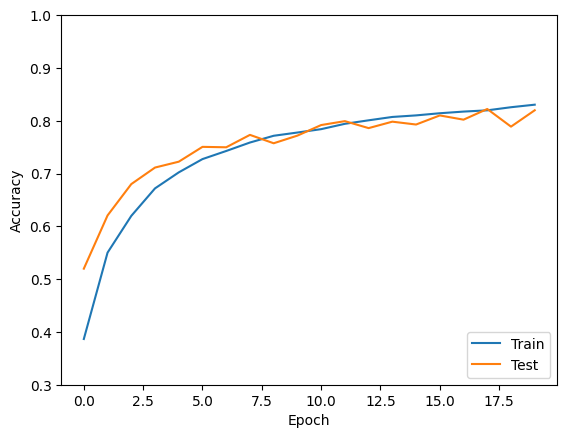

In [ ]:
accuracy_plot(history)

Now we get model that doesn't overfitting and has 81.98% accuracy on training set. Note, this model needs more time for training compared with first model().
Save this model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model2.save('/content/drive/MyDrive/cifar-10/model.keras')

Take a look at confusion matrix

313/313 [==============================] - 1s 4ms/step


<Axes: >

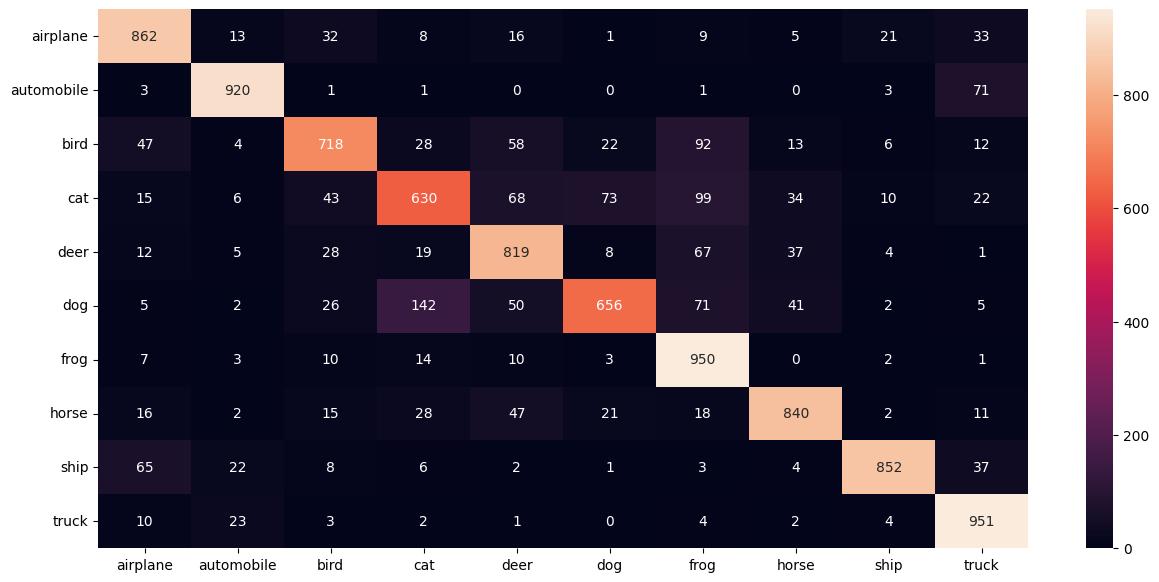

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax (y_pred, axis = 1)
conf_matr = confusion_matrix(y_test,  y_pred)
df_cm = pd.DataFrame(conf_matr, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (15,7))
sn.heatmap(df_cm, annot=True, fmt=".0f")

As we see, model has certain difficulties to classify class cat, dog and bird

Let's test this model on random photo from google <br>
Functions for downloading image by url and get predict for image using the model we want:

In [ ]:
def load_image_by_url(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

In [ ]:
def get_predict(img, model):
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  prob = model.predict(img_array)

  predict = classes[np.argmax(prob)]
  return predict

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/cifar-10/model.keras')

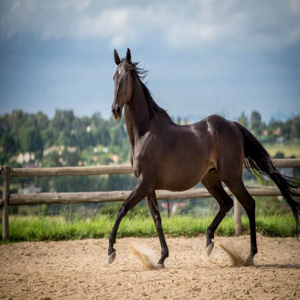

In [ ]:
img = load_image_by_url('https://www.animalife.co.uk/wp-content/uploads/2021/07/Thoroughbred-1024x683.jpg')
img.resize((300, 300))

In [ ]:
get_predict(img, model)

1/1 [==============================] - 0s 39ms/step


'horse'

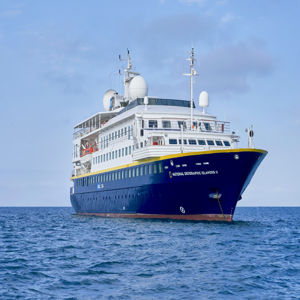

In [ ]:
img = load_image_by_url('https://www.nationalgeographic.com/content/dam/expeditions/transports/islander-ii/new-day-2-islander-ii-jan23-1000x666.jpg')
img.resize((300, 300))

In [ ]:
get_predict(img, model)

1/1 [==============================] - 0s 25ms/step


'ship'

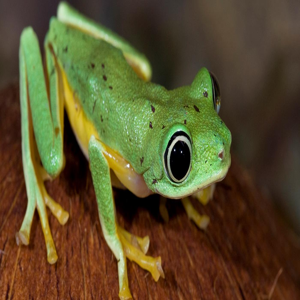

In [ ]:
img = load_image_by_url('https://nationalzoo.si.edu/sites/default/files/styles/wide/public/animals/lemurtreefrog-reverse.jpg?itok=-yQlufG7')
img.resize((300, 300))

In [ ]:
get_predict(img, model)

1/1 [==============================] - 0s 28ms/step


'frog'

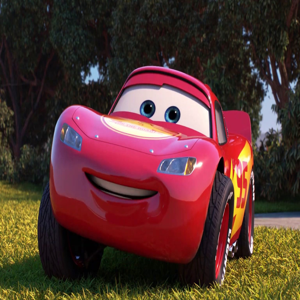

In [ ]:
img = load_image_by_url('https://m.media-amazon.com/images/M/MV5BMzg1NDk0MDYtZjkwNi00NWFiLWIwMmEtMDBmYTM4MjNjMTExXkEyXkFqcGdeQVRoaXJkUGFydHlJbmdlc3Rpb25Xb3JrZmxvdw@@._V1_.jpg')
img.resize((300, 300))

In [ ]:
get_predict(img, model)

1/1 [==============================] - 0s 39ms/step


'automobile'

As a result, we get model with 81.98% accuracy. Adding more layers to this model will increase training time and sligtly increase the accuracy. Also, it's an easiest way to overfitting. Xception model can help get accuracy 90%+ but it needs more computing power. Thus, we obtained a model that has a balance between time for training and classification accuracy